In [1]:
!"C:/Users/alex/AppData/Local/Programs/Python/Python312/python.exe" -m pip install sacrebleu

zsh:1: no such file or directory: C:/Users/alex/AppData/Local/Programs/Python/Python312/python.exe


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import sentencepiece
from tqdm import tqdm
import comet_ml
import sacrebleu
from torch.utils.data import DataLoader

In [4]:
from dataset import WordTokenizer, TextDataset

In [5]:
tokenizer_en = WordTokenizer().fit("data/train.de-en.en")
tokenizer_de = WordTokenizer().fit("data/train.de-en.de")

In [6]:
dataset = TextDataset("data/train.de-en.de", "data/train.de-en.en", min_samples=10)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# train_data, _ = train_test_split(dataset, test_size=0.7)

In [9]:
from model import LanguageModel

In [10]:
loader = DataLoader(dataset, 64, True)

In [11]:
model = LanguageModel(dataset, embed_size=32, hidden_size=32, rnn_layers=1, rnn_type=nn.LSTM)

In [12]:
model.to("mps")

LanguageModel(
  (embedding_en): Embedding(12510, 32, padding_idx=0)
  (embedding_de): Embedding(15033, 32, padding_idx=0)
  (rnn_encoder): LSTM(32, 32, batch_first=True)
  (rnn_decoder): LSTM(64, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=12510, bias=True)
)

In [13]:
from train import train

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Всего параметров: {total_params:,}")

Всего параметров: 1,315,198


/Users/svatoslavpolonskiy/Desktop/bhw_2/train.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


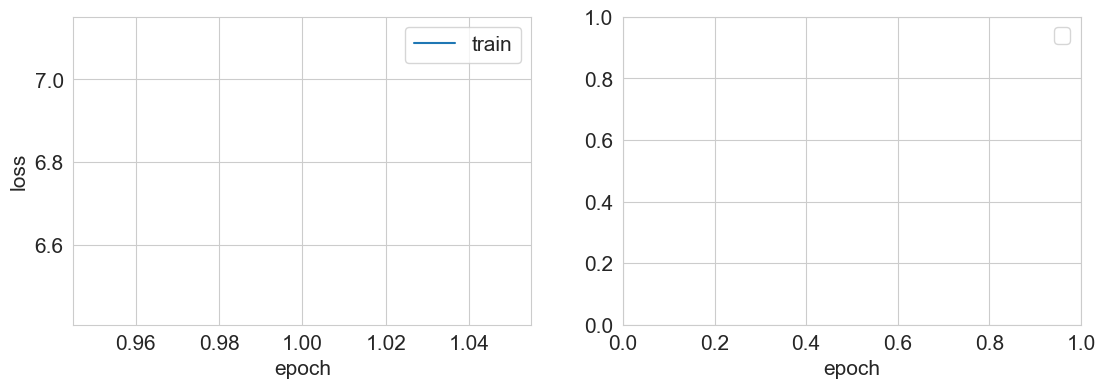

Generation examples:
Doich: <bos> und darunter ist die temperatur , und atmung und sauerstoff . und dann die <unk> .
 <eos>                                                                                                              
Eng: , if
_________________________________________________________________________


Training 2/30:   2%|▏         | 46/3062 [00:49<53:38,  1.07s/it]  


KeyboardInterrupt: 

In [15]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)
   
train(model, optimizer, train_loader=loader, scheduler=scheduler, val_loader=loader, num_epochs=30)